You can access the observing log for the campaign JKT JULY 2003 in  <a href="http://amiga.iaa.es:8888/download/attachments/9569001/jkt_jul03_1.pdf?version=2&modificationDate=1355781458285&api=v2">this file.</a> More information about this campaign can be found in  <a href="http://amiga.iaa.es:8888/display/soft/Location+of+optical+raw+data#Locationofopticalrawdata-Campa%C3%B1aJKTJulio2003">the section of "Location of Optical raw Data" dedicated to this campaign"</a>   

## Campaign dependent data

## Observing log and campaign info

**Directory where data are:** "/home/data/OPTICO/JKT/JUL_03/22"

**Working directory: ** "/home/data/Halpha_reduct_calib/JKT20030722"

## Visual inspection of the data


* Some images show a "hot column" with +~15 counts in the centre of the image, for some biases and science images alike. This might generate an added uncertainty in the bias subtraction. 

* The first three biases where taken ~7 hours before the science images. We will remove them. Unfortunately, they are the ones with the bright column mentioned above. Two of them are more or less compatible with the rest of the biases (only ~1 count over those, on average), but the very first bias is not representative. 

* In some headers the filter is identified as Sloan Gunn, we will rebrand it to Sloan (see 'Fix headers') to avoid problems with the automatic detection of them. 

* Image r326140.fit is to be ignored, according to the log. Also r326172.fit and r326173.fit due to problems with the autoguider. 

* The overscan area is on the top of the image, as DS9 shows it. You will need to see it in a science image, since the overscan reproduces the level of the image so well. 

## Remove images

Files can be removed for several reasons. Saturated images, instrumental malfunction, ... It can be something written in the log, or something that we see when we visually inspect the image. So far, we want to remove:

<table style="width:50%">
  <tr>
    <td>s1.fit</td>
    <td>visual inspection, glance file with short exptime</td>
  </tr>
  <tr>
    <td>r326108.fit</td>
    <td>Bias 7h before observing, different counts</td>
  </tr>
    <td> r326109.fit </td>
    <td> Bias 7h before observing, different counts</td>
  <tr>
    <td> r326110.fit </td>  
    <td> Bias 7h before observing, different counts   </td>
  </tr>
  <tr>
    <td> r326140.fit  </td>
    <td> "Ignore me" written in the log.  </td>
  </tr>
  <tr>
    <td> r326172.fit   </td>
    <td> "Problems with autoguider" according to the log   </td>
  </tr>
  <tr>
    <td>  r326173.fit  </td>
    <td>  "Problems with autoguider" according to the log </td>
  </tr>
  <tr>
    <td>  r326141.fit  </td>
    <td>  Focus image </td>
  </tr>
  <tr>
    <td>  r326142.fit </td>
    <td>  Focus image </td>
  </tr>
  <tr>
    <td>  r326186.fit </td>
    <td>  Low number of counts. Plenty of flats on this filter, so we can remove it.  </td>
  </tr>
  <tr>
    <td>  r326187.fit </td>
    <td>  Low number of counts. Plenty of flats on this filter, so we can remove it. </td>
  </tr>
   <tr>
    <td>  r326199.fit </td>
    <td>  > 60.000 counts, probably not linear anymore. Remove it.  </td>
  </tr>
 </table>

In [1]:
%%bash
rm s1.fit r326108.fit r326109.fit r326110.fit r326140.fit r326172.fit r326173.fit r326141.fit  
rm r326142.fit r326186.fit r326187.fit r326199.fit    

## Merge headers if only one chip

Some telescopes, such as JKT, will include a Primary Header with all the information about telescope, filters and other. Then, they will add the data in a second HDU, with the chip and its own information (gain, read-out noise, sizes, WCS...). This is most inconvenient, and only makes sense for multi-chip images. In case of only one chip, just merge the headers together and put it all in a single HDU. The following piece of code just does a loop over all images in the working folder, opens them, determines if there is only one chip, in which case, finds the main header, adds it to the chip header, removes the main header and saves the file. Easy!

In [2]:
from glob import glob as ls
import os
import astropy.io.fits as fits

image_list = ls( os.path.join(".", "*.fit*") )
for im_name in image_list:
    # Open image, select which layers are chips and which one just a main header (if any)
    HDUList = fits.open(im_name, 'update')
    main_hdr = [ii for ii, _ in enumerate(HDUList) if isinstance(_, fits.hdu.image.PrimaryHDU)]
    chip = [ii for ii, _ in enumerate(HDUList) if isinstance(_, (fits.ImageHDU, fits.hdu.compressed.CompImageHDU))]
    
    # If only one chip, there is a main header, and they are not the same thing, get it all together in one layer
    if len(chip) == 1 and main_hdr is not [] and chip != main_hdr:
        header = HDUList[chip[0]].header + HDUList[main_hdr[0]].header
        data = HDUList[chip[0]].data
        fits.writeto(im_name, data, header, clobber=True)   

## Fix headers 

Unfortunately, **many observatories include WCS keywords in the headers, without bothering including the WCS info properly.** So, not only you have useless, and sometimes old-fashion keywords in the header, but they confuse programs trying to read the headers AFTER you have used astrometry.net. Best solution is to remove them first. 

In [3]:
%%bash
wipe_wcs.py *.fit

Some small fixing in the headers to avoid problems with the automatic routines. For example, the filter system "Sloan Gunn" is not recognized by our routines, so Sloan will be used instead. 

In [4]:
from glob import glob as ls
import os
import astropy.io.fits as fits
image_list = ls( os.path.join(".", "*.fit*") )
for im_name in image_list:
    im = fits.open(im_name, 'update')
    filter_system = im[0].header["JAGFSYS"]
    if 'Sloan' in filter_system and 'Gunn' in filter_system:
        im[0].header["JAGFSYS"] = filter_system.replace("Gunn", "")  
    im.flush()
    im.close()

Also, the filter names can be homogenized. Instead of having 'rGunn', 'Gunn r' and 'gunr' it would be nice to get it all homogeneous. Also, astropy complains that RADECSYS is not a standard keyword for the fits system, so we will substitute it for RADECSYSa. 

In [5]:
import repipy.astroim as astroim
for im_name in image_list:
    im = fits.open(im_name, 'update')
    filter_name = astroim.Astroim(im_name).filter.__str__()
    im[0].header["JAGFBAND"] = filter_name
    try: 
        im[0].header["RADECSYSa"] = im[0].header["RADECSYS"]
        del im[0].header["RADECSYS"]
    except KeyError:
        pass
    im.flush()
    im.close()

RADECSYS is non-standard, use RADESYSa. [astropy.wcs.wcs]
RADECSYS is non-standard, use RADESYSa.
RADECSYS is non-standard, use RADESYSa. [astropy.wcs.wcs]
RADECSYS is non-standard, use RADESYSa.
RADECSYS is non-standard, use RADESYSa. [astropy.wcs.wcs]
RADECSYS is non-standard, use RADESYSa.


All the flats are actually sky flats this night, so we will rebrand them to make sure we have all the information. 

In [6]:
for im_name in image_list:
    im = fits.open(im_name, 'update')
    object_im = im[0].header["OBJECT"]
    if 'flat' in object_im.lower() and 'sky' not in object_im.lower():
        im[0].header["OBJECT"] = "skyflat"  
    im.flush()
    im.close()

## Include WCS in images

We will include the WCS system in all the images using astrometry.net. This will take some minutes (say half a minute per image?), so take it easy ;). 

We will search in a circle of radius 1 deg around the RA,DEC of the header, if found.  

In [7]:
%%bash
astrom.py --overwrite --radius 1 --cosmics *.fit

Reading input file 1 of 1: "/tmp/r326143F71t1L.fits"...
Extracting sources...
simplexy: found 418 sources.
Solving...
Reading file "/tmp/r326143F71t1L.axy"...
Only searching for solutions within 1 degrees of RA,Dec (265.371,5.43443)
Field 1 did not solve (index index-4219.fits, field objects 1-10).
Field 1 did not solve (index index-4218.fits, field objects 1-10).
Field 1 did not solve (index index-4217.fits, field objects 1-10).
Field 1 did not solve (index index-4216.fits, field objects 1-10).
Field 1 did not solve (index index-4215.fits, field objects 1-10).
Field 1 did not solve (index index-4214.fits, field objects 1-10).
Field 1 did not solve (index index-4213.fits, field objects 1-10).
Field 1 did not solve (index index-4212.fits, field objects 1-10).
Field 1 did not solve (index index-4211.fits, field objects 1-10).
Field 1 did not solve (index index-4210.fits, field objects 1-10).
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index i

One of the by-products of the astrom.py routine is the .radec files with the coordinates of all the stars found by astrometry.net. Later on we will refine the astrometry, and those stars will be kept for later use, for the moment we can remove them. 

In [8]:
%%bash
rm *.radec

## Rename files

Rename the files to the format  OBJECT_DATE_FILTER_index.fits, where OBJECT is taken from either the OBJECT keyword in the header or the coordinates of the image, the DATE is taken from the image header, same as the filter (alhough an alias might be used for concision). The index goes from 1 to N, where N is the number of images with the same object and filter. 

The images will be separated in subfolders, such as "cig", "bias", "skyflats", "standards"...

In [9]:
%%bash
rename.py --copy --overwrite .

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:326: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


## Mask  images

Mask out pixels with values above a maximum number of counts

In [10]:
%%bash
create_masks.py --circular --max_val 55000 skyflat/*00?.fits 
create_masks.py --circular --max_val 55000 cig/*00?.fits 
create_masks.py --circular --max_val 55000 standards/*00?.fits 
create_masks.py --circular --max_val 55000 Unknown/*00?.fits 

## Combine bias images 

We will median combine all the bias images to get a master bias. Since it is a bias, no scaling is necessary, and we have chosen the median for the combination because even at zero exposure time you get some cosmic rays in each image. The "--all_together" keyword will tell the program combine.py to ignore the filters of the images, and combine all the images together no matter what filters they have. 

In [11]:
%%bash
cd bias
combine.py --output "masterbias.fits" --average "median" --scale "none" --all_together bias*.fits

## Subtract bias 

Given that the bias has some small amount of structure, we will remove the whole image instead of an average. We will remove it from all other images, which include cig images, flats, standards, bias and even unknown objects, in case they are needed later. We will add a suffix "-b" before the fits extension. The message "masterbias image removed" will be included in the header and the subtraction will not make use of the keywords "--median" or "--mean", which would subtract only the median or mean of the second image. 

In [12]:
%%bash 
arith.py --suffix " -b" --message "Masterbias image removed" cig/cig*.fits - bias/masterbias.fits
arith.py --suffix " -b" --message "Masterbias image removed" skyflat/skyflat_*.fits - bias/masterbias.fits
arith.py --suffix " -b" --message "Masterbias image removed" standards/*.fits - bias/masterbias.fits
arith.py --suffix " -b" --message "Masterbias image removed" Unknown/*00?.fits - bias/masterbias.fits
arith.py --suffix " -b" --message "Masterbias image removed" bias/bias*.fits - bias/masterbias.fits

The subtraction of the bias image leaves some images with a sky level less than zero. This is especially true for images of standards with narrow filters, where the contribution of the sky is almost negligible. The fact that they become negative (by only ~1-2 counts) means the bias was slightly oversubtracted. Since a change in the bias means a similar change in the overscan region, one can subtract the overscan region now and make up for the difference between the areas. 

##Subtract overscan

So, we will next assume that both the bias images and their overscan regions change up/down together, as seems from the bias images, where the difference is negligible. If the bias level has not changed at all during the night, the subtraction of the bias areas would yield zero, as would the overscan region! The same way, if there is a residual on the overscan, the same residual will also be present in the central part of the image. Thus, we can correct for residuals due to changes in the bias level by subtracting an average of the overscan region. 

In [13]:
%%bash
subtract_overscan.py --suffix " -o" --region 2 2080 2055 2119 cig/*-b.fits 
subtract_overscan.py --suffix " -o" --region 2 2080 2055 2119 skyflat/skyflat_*-b.fits
subtract_overscan.py --suffix " -o" --region 2 2080 2055 2119 standards/*-b.fits 
subtract_overscan.py --suffix " -o" --region 2 2080 2055 2119 Unknown/*-b.fits 
subtract_overscan.py --suffix " -o" --region 2 2080 2055 2119 bias/bias*-b.fits

## Combine flats

We will select all the flats to be combined. We do not need to separate them by filters, the routine combine will take care of that. We just need to give all the flats with the bias subtracted (*-b.fits) as input and it will separate them by filter and rename them accordingly. 

In [14]:
%%bash 
cd skyflat/
combine.py --output "masterflats.fits" --average "median" --scale "median" skyflat*-b-o.fits 

The master flats have been constructed. The SDSSr filter is round, the rest square. They show some dead pixels, dead rows and the classical doughnuts of dust in different parts of the optics. All of them show correction of the order of $\le 2\%$ except for the filter Ha6607, where the differences can be up to $\sim 5\%$ even in the central part of the image. 

## Flatfield correction 

One by one, we will flat-field correct all the cig images, standards and skyflats. This would be easiest to do using a program, but we prefer to explicitly show the operations. A lot of "RuntimeWarning: divide by zero [...]" happens in this operation, because it's true, there are a lot of zeroes in the outter parts of the flats images. This will cause no trouble at all, though. They're warnings, not errors.  

In [15]:
%%bash 
arith.py --suffix " -f" --message "Divided by masterflat image" cig/cig*SDSSr*-b-o.fits / skyflat/masterflats_SDSSr.fits
arith.py --suffix " -f" --message "Divided by masterflat image" cig/cig*Ha6645*-b-o.fits / skyflat/masterflats_Ha6645.fits
arith.py --suffix " -f" --message "Divided by masterflat image" cig/cig*Ha6607*-b-o.fits / skyflat/masterflats_Ha6607.fits

arith.py --suffix " -f" --message "Divided by masterflat image" standards/*SDSSr*-b-o.fits / skyflat/masterflats_SDSSr.fits
arith.py --suffix " -f" --message "Divided by masterflat image" standards/*Ha6645*-b-o.fits / skyflat/masterflats_Ha6645.fits
arith.py --suffix " -f" --message "Divided by masterflat image" standards/*Ha6607*-b-o.fits / skyflat/masterflats_Ha6607.fits

arith.py --suffix " -f" --message "Divided by masterflat image" Unknown/*HarrisV*-b-o.fits / skyflat/masterflats_HarrisV.fits
arith.py --suffix " -f" --message "Divided by masterflat image" Unknown/*HarrisR*-b-o.fits / skyflat/masterflats_HarrisR.fits

arith.py --suffix " -f" --message "Divided by masterflat image" skyflat/*SDSSr*-b-o.fits / skyflat/masterflats_SDSSr.fits
arith.py --suffix " -f" --message "Divided by masterflat image" skyflat/*Ha6645*-b-o.fits / skyflat/masterflats_Ha6645.fits
arith.py --suffix " -f" --message "Divided by masterflat image" skyflat/*Ha6607*-b-o.fits / skyflat/masterflats_Ha6607.fits
arith.py --suffix " -f" --message "Divided by masterflat image" skyflat/*HarrisV*-b-o.fits / skyflat/masterflats_HarrisV.fits
arith.py --suffix " -f" --message "Divided by masterflat image" skyflat/*HarrisR*-b-o.fits / skyflat/masterflats_HarrisR.fits


/home/data/python_libraries/repipy/arith.py:47: RuntimeWarning: divide by zero encountered in divide
  result.data[:] = oper(im1.data, value2.data)  # Actual operation of images
/home/data/python_libraries/repipy/arith.py:47: RuntimeWarning: invalid value encountered in divide
  result.data[:] = oper(im1.data, value2.data)  # Actual operation of images
/home/data/python_libraries/repipy/arith.py:47: RuntimeWarning: divide by zero encountered in divide
  result.data[:] = oper(im1.data, value2.data)  # Actual operation of images
/home/data/python_libraries/repipy/arith.py:47: RuntimeWarning: invalid value encountered in divide
  result.data[:] = oper(im1.data, value2.data)  # Actual operation of images
/home/data/python_libraries/repipy/arith.py:47: RuntimeWarning: divide by zero encountered in divide
  result.data[:] = oper(im1.data, value2.data)  # Actual operation of images
/home/data/python_libraries/repipy/arith.py:47: RuntimeWarning: invalid value encountered in divide
  result.dat

## Zero the area outside the circular FoV (not used in this particular run)

For images that have a round FoV, for example, it is quite convenient to bring that area to exactly zero for all the images. This is because the flatfield division we just did has very low counts in that area, probably producing a division by an extremely small number, producing all sort of overflows. In cases where no areas are found outside the FoV nothing is done. 

At the moment the detection of the round area within the square image (filter SDSSr) is not working too well, so we have decided not to use it at all. 

In [16]:
#if circular_FoV:
#    flat_indices = np.where( (list_images["type"] == "skyflats")  |
#                         (list_images["type"] == "flats")     |
#                         (list_images["type"] == "domeflats")   )[0]
#    # Find a suitable mask, which contains number 2, reserved for pixels outside the FoV. 
#    for index in flat_indices:
#        mask_name = fits.getval(list_images["filename"][index], "mask")
#        mask = fits.getdata(mask_name)
#        if np.any(mask == 2):
#            break
#    for im in list_images["filename"]:
#        image = fits.open(im, mode="update")
#        image[0].data[mask==2] = 0
#        image.flush()
#        image.close()

##Trim central area of the image

The outermost area of the images produces lots of trouble. The circular area in the SDSS r filter and the borders of the square ones are not exposed, so the master flat has very small values there. This means that, when dividing by those very small numbers, the corrections in normal images are orders of magnitude the ones in the centre, producing lots of variation that looks like cosmic rays, messing up any statistics in the images, ... We decide to trim the central ~1400 pixels, in an area that has been chosen to make the most of the circular aperture of the SDSS r filter. It was chosen by eye, though, so any other aperture containing the central part of the image and exluding most of the outer nonsensical values is good enough. 

In [19]:
%%bash
trim_images.py --overwrite --region 325 1751 253 1625 --mask_key mask cig/*-o-f.fits
trim_images.py --overwrite --region 325 1751 253 1625 --mask_key mask standards/*-o-f.fits
trim_images.py --overwrite --region 325 1751 253 1625 --mask_key mask Unknown/*-o-f.fits

Killing IRAF task `imcopy'
Traceback (most recent call last):
  File "/home/data/python_libraries/repipy/trim_images.py", line 90, in <module>
    main()
  File "/home/data/python_libraries/repipy/trim_images.py", line 86, in main
    newfile = trim(args)
  File "/home/data/python_libraries/repipy/trim_images.py", line 36, in trim
    imcopy(im_name + "[{0}:{1}, {2}:{3}]".format(x0, x1, y0, y1), temp_output)
  File "/usr/local/lib/python2.7/dist-packages/pyraf/iraftask.py", line 767, in __call__
    return self.run(*args, **kw)
  File "/usr/local/lib/python2.7/dist-packages/pyraf/iraftask.py", line 359, in run
    self._run(redirKW, specialKW)
  File "/usr/local/lib/python2.7/dist-packages/pyraf/iraftask.py", line 811, in _run
    "\n"+str(value))
stsci.tools.irafglobals.IrafError: Error running IRAF task imcopy
IRAF task terminated abnormally
ERROR (808, "Pixel subscript out of bounds (cig/cig0847_20030722_Ha6645_001-b-o-f.fits[253:1625,325:1751])")

Killing IRAF task `imcopy'
Traceb

## Remove cosmics

We wil use cosmics.py, routine that performs for python what Van Dokkun's L.A.cosmic algorithm (http://arxiv.org/abs/astro-ph/0108003) did in IRAF. This is, by far, the most time-comsuming part of the data reduction. Doing 3 iterations per object, it can take easily ~40 minutes, so this might be a good time to go for a coffee. At the end, the images with -c have been stripped from cosmic rays, and the mask locating those cosmic rays (--create_mask option below) are in images with suffix -cosmic_mask. 

In [3]:
%%bash
remove_cosmics.py --suffix " -c" --sigclip 5 --maxiter 2  cig/cig*-b-o-f.fits
remove_cosmics.py --suffix " -c" --sigclip 5 --maxiter 2  standards/*-b-o-f.fits
remove_cosmics.py --suffix " -c" --sigclip 5 --maxiter 2  Unknown/*-b-o-f.fits

bash: line 2: /home/data/python_libraries/repipy/remove_cosmics.py: Permission denied
bash: line 4: /home/data/python_libraries/repipy/remove_cosmics.py: Permission denied
bash: line 6: /home/data/python_libraries/repipy/remove_cosmics.py: Permission denied


## Repeat WCS 

Now that we have done the full data reduction, including bias and cosmic ray removal, we can calculate again the WCS to get a much more refined version. This should also be much faster now that a first WCS is in the header. 

In [2]:
%%bash
wipe_wcs.py cig/cig*-f-c.fits
astrom.py --overwrite --radius 1 cig/*-f-c.fits
astrom.py --overwrite --radius 1 standards/*-f-c.fits
astrom.py --overwrite --radius 1 Unknown/*-f-c.fits

Reading input file 1 of 1: "/tmp/cig0847_20030722_Ha6645_001-b-o-f-ch0wXeY.fits"...
Found an existing WCS header, will try to verify it.
Extracting sources...
simplexy: found 191 sources.
Solving...
Reading file "/tmp/cig0847_20030722_Ha6645_001-b-o-f-ch0wXeY.axy"...
Only searching for solutions within 1 degrees of RA,Dec (272.359,38.7932)
Verifying WCS using indices with quads of size [0.754551, 7.84228] arcmin
Verifying WCS with index 18 of 25 (/usr/local/astrometry/data/index-4203-31.fits)
Verifying WCS of field 1.
  log-odds ratio 108.752 (1.69968e+47), 16 match, 0 conflict, 12 distractors, 20 index.
  RA,Dec = (272.374,38.7864), pixel scale 0.329738 arcsec/pix.
  Hit/miss:   Hit/miss: ++++++++-+++-+----++---+---+(best)----------------------------------------------------------+-------------
 --> log-odds 108.752
Verifying WCS with index 19 of 25 (/usr/local/astrometry/data/index-4203-13.fits)
Verifying WCS of field 1.
 --> log-odds 0
Verifying WCS with index 20 of 25 (/usr/local/as

/usr/local/astrometry/bin/removelines.py:35: RuntimeWarning: divide by zero encountered in log
  logpoisson = k*log(mean) - mean - array([sum(arange(kk)) for kk in k])
/usr/local/astrometry/bin/removelines.py:35: RuntimeWarning: invalid value encountered in multiply
  logpoisson = k*log(mean) - mean - array([sum(arange(kk)) for kk in k])
/usr/local/astrometry/bin/removelines.py:36: RuntimeWarning: invalid value encountered in less
  badbins = occupied[logpoisson < logcut]
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:326: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/usr/local/astrometry/bin/removelines.py:35: RuntimeWarning: divide by zero encountered in log
  logpoisson = k*log(mean) - mean - array([sum(arange(kk)) for kk in k])
/usr/local/astrometry/bin/removelines.py:35: RuntimeWarning: invalid value encountered in multiply
  logpoisson = k*log(mean) - mean - array([sum(arange(kk)) for kk in k])
/usr/local

## Estimate seeing

The routine estimate_seeing.py from repipy takes a catalogue of stars (here we will use the ones given during the WCS solution by astrometry.net) to estimate the seeing. Internally, it just calls psfmeasure, from iraf, and makes sure there is no stars too close, or saturated... The seeing is included in the header under the keyword "seeing". 

In [4]:
%%bash
estimate_seeing.py --wcs world cig/*-f-c.fits
estimate_seeing.py --wcs world standards/*-f-c.fits

/usr/local/lib/python2.7/dist-packages/astropy/modeling/functional_models.py:296: RuntimeWarning: divide by zero encountered in true_divide
  a = 0.5 * ((cost2 / xstd2) + (sint2 / ystd2))
/usr/local/lib/python2.7/dist-packages/astropy/modeling/functional_models.py:297: RuntimeWarning: divide by zero encountered in true_divide
  b = 0.5 * ((sin2t / xstd2) - (sin2t / ystd2))
/usr/local/lib/python2.7/dist-packages/astropy/modeling/functional_models.py:298: RuntimeWarning: divide by zero encountered in true_divide
  c = 0.5 * ((sint2 / xstd2) + (cost2 / ystd2))
/usr/local/lib/python2.7/dist-packages/astropy/modeling/functional_models.py:299: RuntimeWarning: invalid value encountered in add
  return amplitude * np.exp(-((a * xdiff ** 2) + (b * xdiff * ydiff) +
/usr/local/lib/python2.7/dist-packages/astropy/modeling/functional_models.py:297: RuntimeWarning: invalid value encountered in subtract
  b = 0.5 * ((sin2t / xstd2) - (sin2t / ystd2))
/usr/local/lib/python2.7/dist-packages/astropy/mod

## Divide by exptime

We will divide by the exptime, so that all images are in counts per second, and we can scale them to each other. To do so, we give arith the "--keyword exptime", so that the operation uses the value of the keyword EXPTIME in the second image name. 

In [5]:
%%bash
arith.py --keyword exptime --update_keyword --suffix " -t" --message "Divided by exptime" cig/*-f-c.fits  / cig/*-f-c.fits 
arith.py --keyword exptime --update_keyword --suffix " -t" --message "Divided by exptime" standards/*-f-c.fits / standards/*-f-c.fits
arith.py --keyword exptime --update_keyword --suffix " -t" --message "Divided by exptime" Unknown/*-f-c.fits / Unknown/*-f-c.fits

## Photometry of standards

We will do photometry on every one of the three standard stars: Koppf27, BD+253941 and BD+284211. For each of the filters, we will show and fit the slope of the magnitude vs airmass plot. The routine to do the actual photometry is photom.py, which is only a wrapper of lemon's photometry module. 

In [7]:
%%bash
cd standards
photom.py --images kopff*-c-t.fits --output kopff.db --cbox 10 --coordinates kopff27_20030722_SDSSr_001-b-o-f-c.radec
photom.py --images bd+25*-c-t.fits --output bd+253941.db --cbox 10 --coordinates bd+253941_20030723_SDSSr_001-b-o-f-c.radec
photom.py --images bd+28*-c-t.fits --output bd+284211.db --cbox 10 --coordinates bd+284211_20030723_SDSSr_001-b-o-f-c.radec

>> Examining the headers of the 6 FITS files given as input...
>> 100%[======================================================================>]
>> 3 different photometric filters were detected:
>>  SDSS r': 2 files (33.33 %)
>>  Ha 6607: 2 files (33.33 %)
>>  Ha 6645: 2 files (33.33 %)
>> Making sure there are no images with the same date and filter... done.
>> Sources image: kopff27_20030722_Ha6607_001-b-o-f-c-t.fits
>> Running SExtractor on the sources image... done.
>> Calculating coordinates of field center... done.
>> α = 265.9968426  (17 43 59.24)
>> δ =   5.4056744 (+05 24 20.43)
>> Photometry will be done on the 128 coordinates listed in 'kopff27_20030722_SDSSr_001-b-o-f-c.radec'.
>> 
>> Need to determine the instrumental magnitude of each source.
>> Doing photometry on the sources image, using the parameters:
>> FWHM (sources image) = 2.754 pixels, therefore:
>> Aperture radius = 2.754 x 3.00 = 8.262 pixels
>> Sky annulus, inner radius = 2.754 x 6.00 = 16.523 pixels
>> Sky ann

cannot access host 'iraf.noao.edu:80'
cannot access host 'iraf.noao.edu:80'
cannot access host 'iraf.noao.edu:80'


This has created databases for the photometry of each of the standards. In the database there is a lot of information about the images (airmasses, filters, times...) and the photometry of each particular star (magnitude in each image, snr...). We will extract that information and use it to find out the value of the extinction coefficient for each filter. 

## Explore the databases of standards

For each standard star, we will read the airmasses, magnitudes, filters and signal-to-noise ratio (SNR). 

In [9]:
import repipy.extract_mag_airmass_common as extract
X_kopff, mag_kopff, filt_kopff, SNR_kopff, path_kopff = extract.main("standards/kopff.db")
X_bd25, mag_bd25, filt_bd25, SNR_bd25, path_bd25 = extract.main("standards/bd+253941.db")
X_bd28, mag_bd28, filt_bd28, SNR_bd28, path_bd25 = extract.main("standards/bd+284211.db")

To see the shape of the arrays here:

In [10]:
print X_bd25.shape, filt_bd25.shape, SNR_bd25.shape

(69, 7) (69, 7) (69, 7)


so, there are 7 images for calibration star BD+25, where 69 stars were measured. To find out which column belongs to each filter. If we want to know the filter of the images (we only show the data for the first five stars, the rest are exactly equal): 

In [11]:
print filt_bd25[0:5,:]

[["SDSS r'" "SDSS r'" 'Ha 6607' 'Ha 6607' 'Ha 6607' 'Ha 6645' 'Ha 6645']
 ["SDSS r'" "SDSS r'" 'Ha 6607' 'Ha 6607' 'Ha 6607' 'Ha 6645' 'Ha 6645']
 ["SDSS r'" "SDSS r'" 'Ha 6607' 'Ha 6607' 'Ha 6607' 'Ha 6645' 'Ha 6645']
 ["SDSS r'" "SDSS r'" 'Ha 6607' 'Ha 6607' 'Ha 6607' 'Ha 6645' 'Ha 6645']
 ["SDSS r'" "SDSS r'" 'Ha 6607' 'Ha 6607' 'Ha 6607' 'Ha 6645' 'Ha 6645']]


Three images for Ha6607, two for the other two. And the airmasses of those images are: 

In [12]:
print X_bd25[0:5,:]

[[ 1.008396  1.502021  1.006231  1.519009  1.0071    1.004275  1.536567]
 [ 1.008396  1.502021  1.006231  1.519009  1.0071    1.004275  1.536567]
 [ 1.008396  1.502021  1.006231  1.519009  1.0071    1.004275  1.536567]
 [ 1.008396  1.502021  1.006231  1.519009  1.0071    1.004275  1.536567]
 [ 1.008396  1.502021  1.006231  1.519009  1.0071    1.004275  1.536567]]


## Calculate the extinction coefficient

We will use calculate_extinction.py to estimate the extinction for all the standard stars and filters. 

In [13]:
%%bash
cd standards
calculate_extinction.py --nstars 5 --plot kopff.db bd+253941.db bd+284211.db


Studying database kopff.db:
Airmasses are too close for filter Ha 6607 
Airmasses are too close for filter Ha 6645 
Airmasses are too close for filter SDSS r' 

Studying database bd+253941.db:
Extinction coefficient for filter Ha 6607: 0.257200519464 +- 0.0239627039123
Extinction coefficient for filter Ha 6645: 0.267265724445 +- 0.00651075789302
Extinction coefficient for filter SDSS r': 0.304136380305 +- 0.00548012419935

Studying database bd+284211.db:
Airmasses are too close for filter Ha 6607 
Airmasses are too close for filter Ha 6645 
Airmasses are too close for filter SDSS r' 


It says right there that the airmasses are too close for the images of bd+28 and kopff27. Is that so?

In [14]:
print X_kopff[0,:], "\n", X_bd28[0,:]

[ 1.166843  1.151739  1.158307  1.158816  1.164835  1.148548] 
[ 1.078536  1.17078   1.083404  1.163018  1.087989  1.145841]


Yes, the images of Kopff27 for SDSS (first two numbers), Ha6607 and Ha6645 are almost exactly the same, about 1.16. The same happens for the images of BD+28, they are all around 1.1. Thus, the errors in the photometry of individual images will be larger than the differences produced by such small changes in the airmass, so the fits would be worthless. 

## Apply excintcion correction

The equation for the extinction correction is:  
$$m = m_0 - \kappa * X $$  
where $\kappa$ is the extinction coefficient and $m$ is the magnitude as measured without extinction and $m_0$ the extinguished version of it, we can get:

$$ m - m_o= -2.5 * \log \left( \frac{flux}{flux_0} \right) \Rightarrow flux = flux_0 * 10^\left( \frac{\kappa X}{2.5}\right)$$ 
And that can be done with the program correct_extinction.py:

In [15]:
%%bash
correct_extinction.py --input ./cig/*-c-t.fits --coeff Ha6607 0.26 0.02 \
                      --coeff Ha6645 0.267 0.007 \
                      --coeff SDSSr 0.304 0.005 --suffix " -e"
correct_extinction.py --input ./standards/*-c-t.fits --coeff Ha6607 0.26 0.02 \
                      --coeff Ha6645 0.267 0.007 \
                      --coeff SDSSr 0.304 0.005 --suffix " -e"

## Calculate zero point

The zero point is the conversion factor between counts and flux, so that the images are calibrated. It is usually written in magnitudes: 

$$m = -2.5 * \log \left( \frac{\textrm{counts}}{\textrm{second}} \right) + \textrm{zp} $$

where **counts** is corrected of extinction correction and **zp** is the zero point that will convert the magnitudes to a calibrated system (such as Vega or AB magnitudes). Please, notice that the conversion is between counts and fluxes, which means that any and all steps of the data reduction will affect the zero point. If, for example, the flats where normalized to the mean of the central region of the flat, the zero point will be slightly different that if the median or the maximum were used. 

In this step, we will calculate the zero point for each filter. We will get an estimate of the zp from each image of each standard star (i.e. all images with *-e.fits), then we will average the zero points for each filter.

In [16]:
%%bash
calculate_zeropoint.py standards/*Ha6645*-t-e.fits
calculate_zeropoint.py standards/*Ha6607*-t-e.fits
calculate_zeropoint.py standards/*SDSSr*-t-e.fits


 Zero point for filter Ha6645: 
 zp = 35.9891985307, std_zp = 0.0325006196529 


 Zero point for filter Ha6607: 
 zp = 36.0662559, std_zp = 0.0501170833748 


 Zero point for filter SDSSr: 
 zp = 35.7955411105, std_zp = 0.052322835372 



/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:326: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:326: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:326: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


## Estimate sky

The sky is estimated by fitting a Gaussian to the 'clipped' (just a second) data. The clipping is done using the median and the <a href="https://en.wikipedia.org/wiki/Median_absolute_deviation">median absolute deviation (MAD)</a>, two robust estimators of average and variability. More in detail, we have selected the pixels that are within $7.5 MAD$ of the median, which if the distribution was Gaussian would equate to a $5\sigma$ clipping. This is not a severe constraint, and will get rid of most of the pixels belonging to galaxies and stars. If there is a mask for the image, the name of the mask should be in the header, and the key for that mask should be passed using the '--mask_key' option. Another option, the '--plot' would be useful to see the actual final fits to the sky, where hopefully you will see how nicely represented the sky is by a Gaussian.     

In [17]:
%%bash
find_sky.py --mask_key MASK cig/cig*-t-e.fits
find_sky.py --mask_key MASK standards/*-t-e.fits

##Match PSFs

Before combining images, we should first match the PSFs, so that all the images have the same spatial resolution. We do this with match_psfs.py, and we match all the images of the same object independent of the filter, since we are going to use the continuum image to subtract it from the Halpha image and so on. The measured seeings from the header will help sort the images and decide which one to use as a reference, but at the end of the day, a full model of the PSFs of both images is performed using IRAF's PSF and PSFMatch. 

On the other hand, if the PSFs are close enough, it is best not to match the PSFs, since it would introduce extra uncertainties and will produce a correlation of noise in the pixels of the image. How much is "close enough"? If you have used estimate_seeing.py as I did above, you should have in your images a seeing_MAD keyword that tells you the median absolute deviation of the PSFs of the individual stars in the image. If your images are anything like mine, you'll see that value is between 0.2 and 0.5 pixels or so. That means that the median deviation within stars of the same image is in that range. Well, 0.2 is the limit below which no psf matching is done, but that can be changed using --limit in call to match_psfs.py below. 

The main parameters of match_psfs.py are the input star list, the keyword to the sigma of the sky in each image, the airmass and the usual keywords of information about the camera (gain, read_out_noise, exposure_time, ...). 

In [18]:
%%bash 
match_psfs.py --input_stars cig/cig0847_20030722_Ha6645_001-b-o-f-c.radec --suffix " -m" --sigma_key sky_std \
              --gain_key GAIN --ron_key READNOIS --expt_key EXPTIME --airm_key AIRMASS --FWHM_key SEEING --limit 0.2 \
              cig/cig0847*-c-t-e.fits
match_psfs.py --input_stars cig/cig0879_20030723_Ha6645_001-b-o-f-c.radec --suffix " -m" --sigma_key sky_std \
              --gain_key GAIN --ron_key READNOIS --expt_key EXPTIME --airm_key AIRMASS --FWHM_key SEEING --limit 0.2 \
              cig/cig0879*-c-t-e.fits
match_psfs.py --input_stars cig/cig1047_20030723_Ha6607_001-b-o-f-c.radec --suffix " -m" --sigma_key sky_std \
              --gain_key GAIN --ron_key READNOIS --expt_key EXPTIME --airm_key AIRMASS --FWHM_key SEEING --limit 0.2 \
              cig/cig1047*-c-t-e.fits

Completed computing/reading kernel kernel.fits for image cig/cig0847_20030722_Ha6645_002-b-o-f-c-t-e.fits
Completed computing/reading kernel kernel.fits for image cig/cig0847_20030722_Ha6645_003-b-o-f-c-t-e.fits
Completed computing/reading kernel kernel.fits for image cig/cig0847_20030722_Ha6645_004-b-o-f-c-t-e.fits
Completed computing/reading kernel kernel.fits for image cig/cig0847_20030722_Ha6645_001-b-o-f-c-t-e.fits
Completed computing/reading kernel kernel.fits for image cig/cig0879_20030723_Ha6645_002-b-o-f-c-t-e.fits
Completed computing/reading kernel kernel.fits for image cig/cig0879_20030723_Ha6645_003-b-o-f-c-t-e.fits
Completed computing/reading kernel kernel.fits for image cig/cig0879_20030723_Ha6645_001-b-o-f-c-t-e.fits
Completed computing/reading kernel kernel.fits for image cig/cig0879_20030723_SDSSr_004-b-o-f-c-t-e.fits
Completed computing/reading kernel kernel.fits for image cig/cig1047_20030723_Ha6607_001-b-o-f-c-t-e.fits
Completed computing/reading kernel kernel.fits 

##Merge images

Time to combine the images, this time separating by filters. We will use the combine.py task, as we did above for the bias and flats. We will not scale the images at all, after the extinction correction they should all be at the same scale, and we will use the mean to average them. 

In [1]:
%%bash 
cd cig
combine_wcs.py --output cig0847_SDSSr_combined.fits --average mean --scale None cig0847*SDSS*-e-m.fits  
combine_wcs.py --output cig0847_Ha6645_combined.fits --average mean --scale None cig0847*Ha6645*-e-m.fits  
combine_wcs.py --output cig0879_SDSSr_combined.fits --average mean --scale None cig0879*SDSS*-e-m.fits  
combine_wcs.py --output cig0879_Ha6645_combined.fits --average mean --scale None cig0879*Ha6645*-e-m.fits  
combine_wcs.py --output cig1047_SDSSr_combined.fits --average mean --scale None cig1047*SDSS*-e-m.fits  


Oct 20 14:37: IMCOMBINE
  combine = average, scale = none, zero = none, weight = none
  blank = 0.
                Images    Offsets
  cig0847_20030722_SDSSr_001-b-o-f-c-t-e-m.fits    2    0
  cig0847_20030722_SDSSr_002-b-o-f-c-t-e-m.fits    2    0
  cig0847_20030722_SDSSr_003-b-o-f-c-t-e-m.fits    1    0
  cig0847_20030722_SDSSr_004-b-o-f-c-t-e-m.fits    0    1

  Output image = cig0847_SDSSr_combined.fits, ncombine = 4

Oct 20 14:37: IMCOMBINE
  combine = average, scale = none, zero = none, weight = none
  blank = 0.
                Images    Offsets
    /tmp/tmpWx1cXl.fits    2    0
    /tmp/tmpcVOPJO.fits    2    0
    /tmp/tmpXQNxL0.fits    1    0
    /tmp/tmptpiYGa.fits    0    1

  Output image = /tmp/tmpdi4snM.fits, ncombine = 4

Oct 20 14:37: IMCOMBINE
  combine = average, scale = none, zero = none, weight = none
  blank = 0.
                Images    Offsets
  cig0847_20030722_Ha6645_001-b-o-f-c-t-e-m.fits    0   15
  cig0847_20030722_Ha6645_002-b-o-f-c-t-e-m.fits  209    5


##Some concerns about continuum subtraction

So far we have both the narrow and broad band images combined. We now want to subtract the continuum, as measured from the broad image, from the narrow one. This is usually done by scaling the broad-band image to the image with the H$\alpha$ filter by measuring the flux of the stars in both filters and calculating the ratio needed for them to coincide. The way of reasoning behind this is that the stars have mostly continuum emission. Then, the ratio between the two filters will give us a scaling factor. 

First, let's plot the filter curves of two filters used tonight: R and Ha6645, and the spectra of two standard stars: bd+284211 and hiltner102. 

In [8]:
import repipy
import numpy
import os
repipy_dir = repipy.__path__[0]
path_to_R = os.path.join(repipy_dir, "filters/jkt_216")
path_to_Ha = os.path.join(repipy_dir, "filters/jkt_66")
path_to_bd28 = os.path.join(repipy_dir, "standard_spectra/bd284211")
path_to_hilt102 = os.path.join(repipy_dir, "standard_spectra/hiltner102")


rgunn_wav, rgunn_trans = numpy.genfromtxt( path_to_R, unpack=True )
Ha_wav, Ha_trans = numpy.genfromtxt( path_to_Ha, unpack=True)
bd28_wav, bd28_mag = numpy.genfromtxt( path_to_bd28, unpack=True, skip_header=18)
hilt102_wav, hilt102_mag = numpy.genfromtxt( path_to_hilt102, unpack=True, skip_header=18)
bd28_flux = 10**((13.5-bd28_mag) / 2.5)
hilt102_flux = 10**((13.5-hilt102_mag)/2.5)

# If Ha_wav and rgunn_wav are in nanometers, pass to Angstr
if rgunn_wav[0] < 2000:
    rgunn_wav = rgunn_wav * 10
if Ha_wav[0] < 2000:
    Ha_wav = Ha_wav * 10


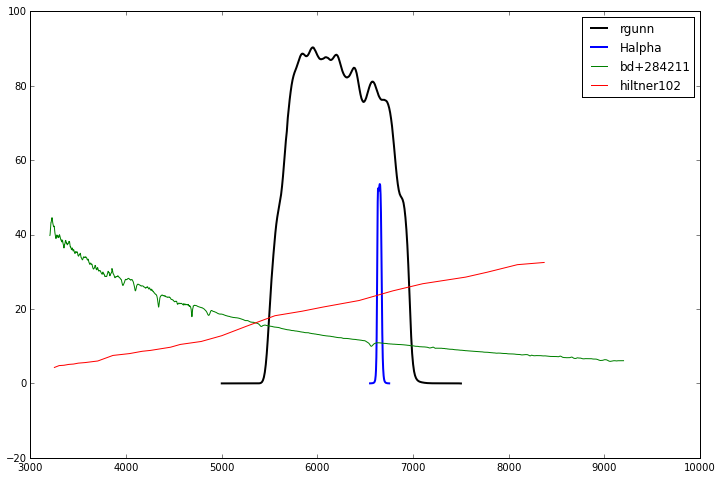

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(1,(12,8))
plt.plot(rgunn_wav , rgunn_trans, '-k', linewidth=2, label="rgunn")
plt.plot(Ha_wav , Ha_trans, '-b', linewidth=2, label="Halpha")
plt.plot(bd28_wav, bd28_flux, '-g', label="bd+284211")
plt.plot(hilt102_wav, hilt102_flux, '-r', label="hiltner102")
plt.legend()
plt.show()

We can visually see how the proportion of the light of bd+284211 that falls within the narrow filter will be much smaller than the one for hiltner102, since one is decaying while the other is ascending with wavelength. The proportion of light within the narrow filter will mostly depend on the transmittance of the filters, and on their width, but the exact shape of the continuum will affect the ratio too, as we see here. 

A possible solution to this problem is to look for stars within the image that have similar colours to the galaxy, for example, as seen from Sloan. Assuming the contribution of the lines to the broad filters is small (which most likely it is, even for Starbursts the contribution of H$\alpha$ is ~10%), the slope of the continuum will be well represented by, for example, $g-r$  or  $r-i$ and can be better represented with stars of the same slope.  

##Scale images

Despite the concerns above, there is little we can do when our galaxies are not in an optical survey, such as SDSS. Of the three CIGs in tonight's sample, CIG 1047, 847 and 879, only 1047 is in Sloan, but we only have 1 Halpha image on this galaxy (just after that, on the log, there is observations of a supernova). 847 and 879 are not observed in the red part of the optical according to NED, so we will have to scale using the average of all the stars in the field, since it is impossible to select stars that are similar in continuum to the average colour of the galaxy. 

We will do photometry stars in both the broad and narrow band images, and calculate the factor by which we will multiply the broad-band flux of the stars to get the factor by which it need to be multiplied to equate the narrow-band flux. We will use the program scale_images.py. In this case, the image of Halpha is the one we want as a reference, which means we want to scale the image with the brightest objects to the one with the faintest ones, exactly the contrary to what we would do in the case, for example, that we were scaling to the image with the smallest airmass in a photometric night, in which case we would want to scale to the brightest object! 

In [16]:
from repipy import scale_images
images = ["cig/cig0847_Ha6645_combined.fits", "cig/cig0847_SDSS_combined.fits"]
star_coords = "cig/cig0847_20030722_Ha6645_001-b-o-f-c.radec"
scale_to = "minimum"  # because we want to scale to the faintest of the two images, the Halpha
scale_images.main(images, star_coords, scale_to)

MaskError: Mask and data not compatible: data size is 2281244, mask size is 3253716.